# Polynomial Regression

## Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg

sys.path.append('../')

from utils.metrics import mse, rmse
from utils.scalers import StandardScaler
from utils.preprocessing import train_test_split

## Process

In [2]:
class MyPolynomialRegression:
    def __init__(self, polynomial_degree):
        self.polynomial_degree = polynomial_degree
        self.fitted = False


    def insert_polynomial_features(self, X):
        intercept = X[:, [0]]
        features = X[:, 1:]

        X_poly = features
        if self.polynomial_degree > 1:
            for i in range(2, self.polynomial_degree+1):
                X_poly = np.hstack([X_poly, features**i])
        
        X_poly = np.hstack([intercept, X_poly])

        return X_poly


    # Fit with OLS
    def fit_ols(self, X, y, reg_lambda=0):
        if not all(X[:, 0] == 1):
            raise Exception('The first column must be the intercept column (X[0])')

        X = self.insert_polynomial_features(X)

        self.X_scaler = StandardScaler()
        X = np.hstack([X[:, [0]], self.X_scaler.fit_transform(X[:, 1:])])
        self.y_scaler = StandardScaler()
        y = self.y_scaler.fit_transform(y)

        matrix_to_mitigate_numerical_problems = (10 ** -8) * np.eye(X.shape[1], X.shape[1])
        reg_matrix = np.eye(X.shape[1], X.shape[1]) * reg_lambda
        reg_matrix[0, 0] = 0

        w_hat = (np.linalg.pinv(X.T @ X + reg_matrix + matrix_to_mitigate_numerical_problems) @ X.T) @ y
        self.w = w_hat.reshape(-1, 1)
        self.fitted = True


    def predict(self, X):
        if self.fitted:
            if not all(X[:, 0] == 1):
                raise Exception('The first column must be the intercept column (X[0])')
            
            X = self.insert_polynomial_features(X)
            X = np.hstack([X[:, [0]], self.X_scaler.transform(X[:, 1:])])

            y_pred = (X @ self.w).reshape(-1, 1)
            y_pred = self.y_scaler.inverse_transform(y_pred)

            return y_pred
        else:
            raise Exception('Model not fitted!')


In [3]:
data = np.genfromtxt('./data/california.csv', delimiter=',')

X = data[:, :-1]
y = data[:, [-1]]

print('Visualizing data')
data[:2,:]

Visualizing data


array([[   4.1685    ,   20.        ,    6.70063694,    1.17834395,
         745.        ,    2.37261146,   38.8       , -121.15      ,
           2.175     ],
       [   2.8194    ,   24.        ,    4.7625    ,    1.02083333,
         608.        ,    2.53333333,   36.75      , -119.85      ,
           0.811     ]])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 8)
y_train shape: (4000, 1)
X_test shape: (1000, 8)
y_test shape: (1000, 1)


## Without Regularization

In [5]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [6]:
print('Polynomial Regression')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942386      0.669167        
3       0.63777556      0.783326        
4       0.63049651      1.496323        
5       0.62816833      1.116705        
6       0.62620777      1.514286        
7       0.62128961      113.901176      
8       0.62020727      732.393264      
9       0.62019605      839.769066      
10      0.62005348      160.272249      
11      0.61955882      2662.575268     


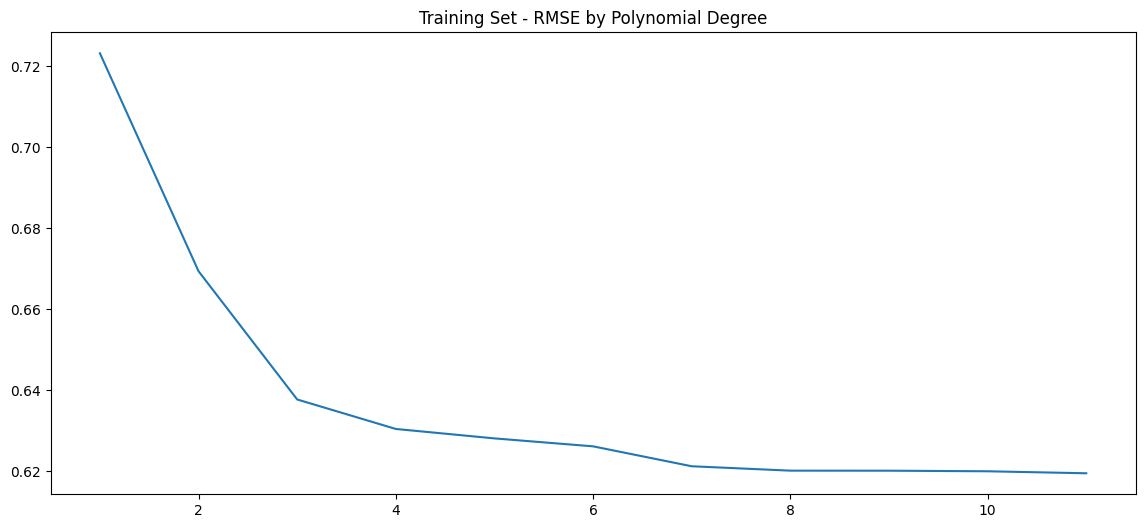

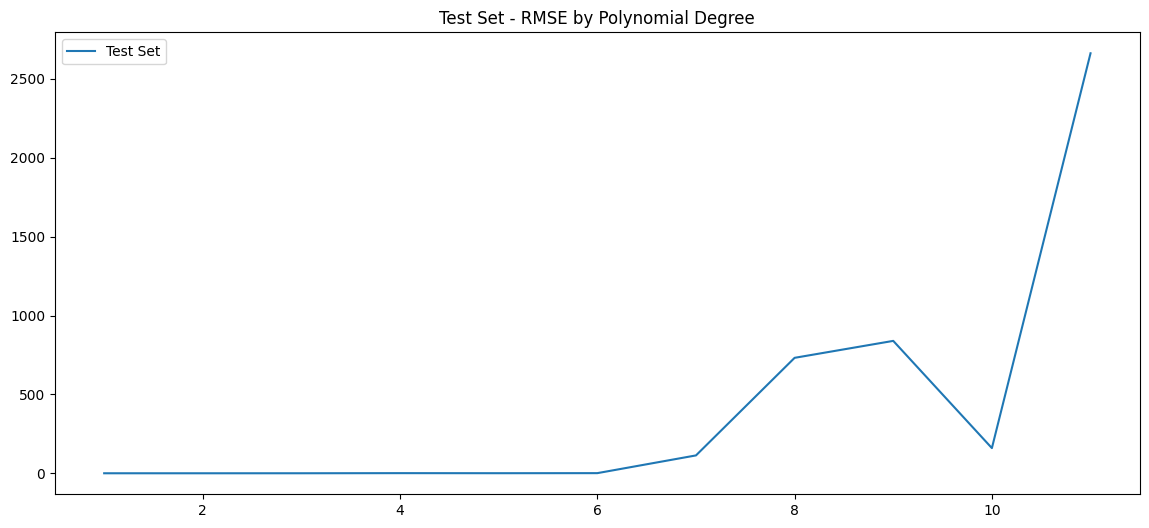

In [7]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()

## With Regularization (lambda=0.001)

In [8]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0.001)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [9]:
print('Polynomial Regression with L2 Regularization (lambda=0.001)')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression with L2 Regularization (lambda=0.001)
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942424      0.669181        
3       0.65069351      0.768951        
4       0.64674961      1.418320        
5       0.64495673      0.837795        
6       0.64441665      1.124933        
7       0.64404116      8.969059        
8       0.64318765      31.159555       
9       0.64206431      72.894065       
10      0.64124400      129.035566      
11      0.64088871      168.668158      


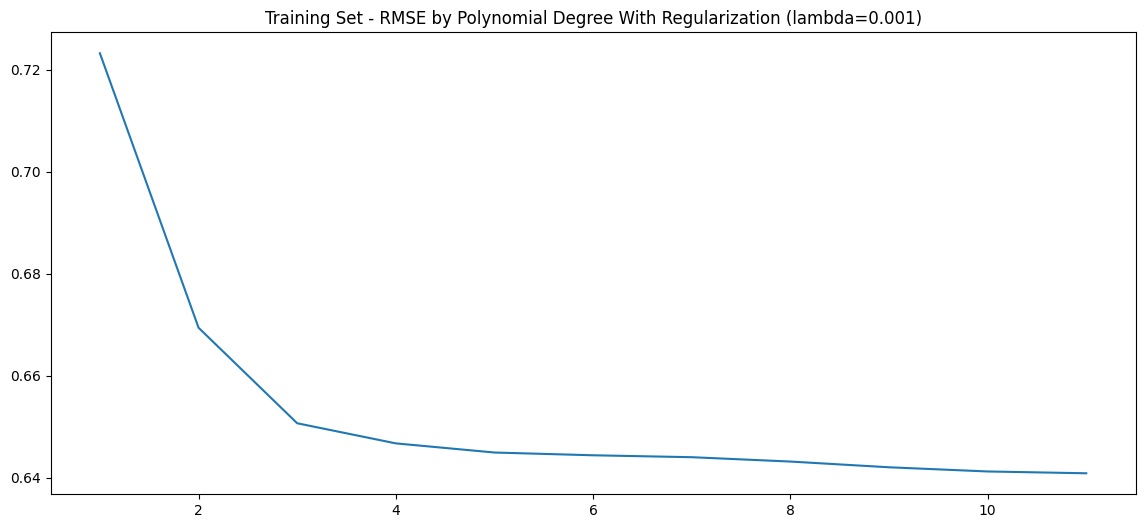

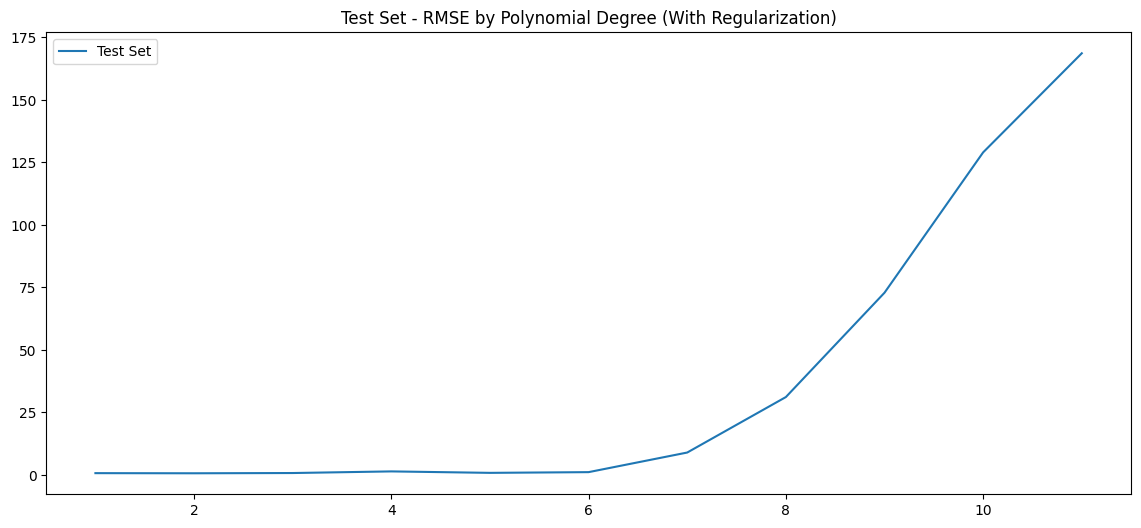

In [10]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree With Regularization (lambda=0.001)')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree (With Regularization)')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()